<a href="https://colab.research.google.com/github/hadagarcia/zerotogans/blob/main/notebooks/02_insurance_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.utils.colab.set_colab_file_id('1trscVUPkUd4O-4ECNojXgRsHrVBtiJub')

# Insurance cost prediction using linear regression

Make a submisson here: https://jovian.ai/learn/deep-learning-with-pytorch-zero-to-gans/assignment/assignment-2-train-your-first-model

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from [Kaggle](https://www.kaggle.com/mirichoi0218/insurance).


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lessons. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ai/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ai/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ai/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [ ]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [ ]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

In [ ]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [ ]:
your_name = 'balbina' # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [ ]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [ ]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,region,charges
1306,29,female,21.1945,0,yes,northeast,17404.528860
206,59,male,25.6080,0,no,southeast,12682.762920
191,36,female,25.4140,0,no,southwest,5274.575280
573,62,female,35.7542,1,no,northeast,34149.601145
76,29,female,28.7023,1,no,southeast,4263.206148


In [ ]:
type(dataframe)

pandas.core.frame.DataFrame

Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [ ]:
num_rows = len(dataframe)
print(num_rows)

1271


**Q: How many columns does the dataset have**

In [ ]:
_, num_cols = dataframe.shape
print(num_cols)

7


In [ ]:
# To make it easier to answer the following questions, I'll divide the dataframe in input and output columns
dataframe_inputs = dataframe[dataframe.columns[:6]]
print(dataframe_inputs.head(2))

dataframe_outputs = dataframe[dataframe.columns[-1:]]
print(dataframe_outputs.head(2))


      age     sex      bmi  children smoker     region
1306   29  female  21.1945         0    yes  northeast
206    59    male  25.6080         0     no  southeast
          charges
1306  17404.52886
206   12682.76292


**Q: What are the column titles of the input variables?**

In [ ]:
input_cols = list(dataframe_inputs.columns)
print(input_cols[:6]) # 'age', 'sex', 'bmi', 'children', 'smoker', 'region'

['age', 'sex', 'bmi', 'children', 'smoker', 'region']


**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [ ]:
categorical_cols = list(dataframe_inputs.select_dtypes(exclude=np.number).columns)
print(categorical_cols)

['sex', 'smoker', 'region']


**Q: What are the column titles of output/target variable(s)?**

In [ ]:
output_cols = list(dataframe_outputs.columns)
print(output_cols)

['charges']


**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

In [ ]:
# Write your answer here
values = dataframe_outputs.describe()
values

,charges
count,1271.000000
mean,14436.984079
std,13209.435806
min,1211.623812
25%,5107.322565
50%,10163.885400
75%,18187.921408
max,68872.062251


In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style("darkgrid")
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (9, 5)

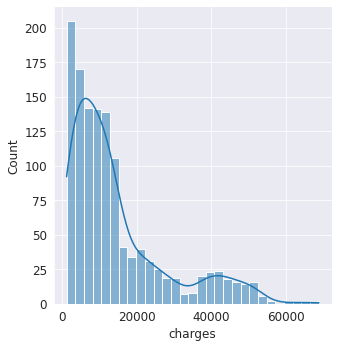

In [ ]:
sns.displot(dataframe_outputs, x="charges", kde=True);

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays. If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays.

In [ ]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        dataframe1[col] = dataframe1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(dataframe)
inputs_array, targets_array

(array([[29.     ,  0.     , 21.1945 ,  0.     ,  1.     ,  0.     ],
        [59.     ,  1.     , 25.608  ,  0.     ,  0.     ,  2.     ],
        [36.     ,  0.     , 25.414  ,  0.     ,  0.     ,  3.     ],
        ...,
        [40.     ,  0.     , 40.1774 ,  1.     ,  0.     ,  1.     ],
        [52.     ,  0.     , 17.78495,  0.     ,  0.     ,  1.     ],
        [39.     ,  1.     , 34.241  ,  2.     ,  1.     ,  3.     ]]),
 array([[17404.52886  ],
        [12682.76292  ],
        [ 5274.57528  ],
        ...,
        [30754.8737892],
        [10790.320662 ],
        [43312.2012   ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [ ]:
inputs = torch.tensor(inputs_array, dtype=torch.float32)
targets = torch.tensor(targets_array, dtype=torch.float32)

In [ ]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [ ]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets.**

In [ ]:
val_percent = 0.15 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [train_size, val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

In [ ]:
len(train_ds), len(val_ds)

(1081, 190)

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [ ]:
batch_size = 32

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[43.0000,  1.0000, 33.9112,  1.0000,  1.0000,  0.0000],
        [41.0000,  1.0000, 35.9385,  2.0000,  0.0000,  1.0000],
        [50.0000,  0.0000, 27.2764,  3.0000,  0.0000,  1.0000],
        [46.0000,  0.0000, 46.6279,  2.0000,  0.0000,  0.0000],
        [29.0000,  1.0000, 22.2082,  0.0000,  1.0000,  0.0000],
        [24.0000,  1.0000, 25.0260,  0.0000,  0.0000,  3.0000],
        [38.0000,  0.0000, 39.3480,  1.0000,  0.0000,  1.0000],
        [62.0000,  1.0000, 37.6651,  0.0000,  0.0000,  2.0000],
        [51.0000,  1.0000, 24.6380,  0.0000,  0.0000,  3.0000],
        [33.0000,  0.0000, 21.4709,  1.0000,  0.0000,  0.0000],
        [34.0000,  0.0000, 22.8532,  0.0000,  0.0000,  0.0000],
        [19.0000,  0.0000, 27.0921,  3.0000,  0.0000,  1.0000],
        [29.0000,  1.0000, 33.3680,  0.0000,  1.0000,  3.0000],
        [33.0000,  0.0000, 37.7330,  3.0000,  0.0000,  3.0000],
        [35.0000,  1.0000, 38.5187,  4.0000,  0.0000,  0.0000],
        [41.0000,  0.0000, 32.06

Let's save our work by committing to Jovian.

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/hada-garcia/02-insurance-linear-regression


'https://jovian.ai/hada-garcia/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [ ]:
input_size = len(input_cols)
output_size = len(output_cols)

In [ ]:
input_size, output_size

(6, 1)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss function (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

In [ ]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                 # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                      # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                         # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [ ]:
insuranceModel = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [ ]:
list(insuranceModel.parameters())

[Parameter containing:
 tensor([[ 0.2986, -0.1532,  0.2264,  0.2474,  0.2430,  0.3250]],
        requires_grad=True), Parameter containing:
 tensor([0.2350], requires_grad=True)]

One final commit before we train the model.

In [ ]:
jovian.commit(project=project_name, environment=None)

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [ ]:
result = evaluate(insuranceModel, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 14147.5087890625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `insuranceModel = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [ ]:
epochs = 500
lr = 5e-3
history1 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 8467.4131
Epoch [40], val_loss: 7822.5508
Epoch [60], val_loss: 7773.2905
Epoch [80], val_loss: 7734.6665
Epoch [100], val_loss: 7699.5903
Epoch [120], val_loss: 7665.3301
Epoch [140], val_loss: 7633.0610
Epoch [160], val_loss: 7601.4858
Epoch [180], val_loss: 7571.3550
Epoch [200], val_loss: 7541.2310
Epoch [220], val_loss: 7511.9272
Epoch [240], val_loss: 7482.9956
Epoch [260], val_loss: 7457.5962
Epoch [280], val_loss: 7434.9087
Epoch [300], val_loss: 7413.9648
Epoch [320], val_loss: 7395.1382
Epoch [340], val_loss: 7379.1470
Epoch [360], val_loss: 7366.8555
Epoch [380], val_loss: 7356.9590
Epoch [400], val_loss: 7350.3647
Epoch [420], val_loss: 7344.9146
Epoch [440], val_loss: 7341.9800
Epoch [460], val_loss: 7339.2144
Epoch [480], val_loss: 7336.2505
Epoch [500], val_loss: 7333.1431


In [ ]:
epochs = 500
lr = 0.70
history2 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 7261.6831
Epoch [40], val_loss: 7224.1294
Epoch [60], val_loss: 7168.1499
Epoch [80], val_loss: 7133.9395
Epoch [100], val_loss: 7148.5532
Epoch [120], val_loss: 7069.2246
Epoch [140], val_loss: 7045.1616
Epoch [160], val_loss: 7036.4258
Epoch [180], val_loss: 6990.4741
Epoch [200], val_loss: 7017.4731
Epoch [220], val_loss: 7015.0679
Epoch [240], val_loss: 6944.4941
Epoch [260], val_loss: 6987.7446
Epoch [280], val_loss: 6878.8101
Epoch [300], val_loss: 6963.3149
Epoch [320], val_loss: 6838.1289
Epoch [340], val_loss: 6872.1616
Epoch [360], val_loss: 6804.7944
Epoch [380], val_loss: 6836.7891
Epoch [400], val_loss: 6748.6899
Epoch [420], val_loss: 6723.7534
Epoch [440], val_loss: 7096.6406
Epoch [460], val_loss: 6814.9868
Epoch [480], val_loss: 6698.9790
Epoch [500], val_loss: 6668.5430


In [ ]:
epochs = 500
lr = 0.65
history3 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 6162.6538
Epoch [40], val_loss: 6162.4907
Epoch [60], val_loss: 6192.8535
Epoch [80], val_loss: 6099.5879
Epoch [100], val_loss: 6128.9961
Epoch [120], val_loss: 6113.5039
Epoch [140], val_loss: 6072.2891
Epoch [160], val_loss: 6029.5449
Epoch [180], val_loss: 6011.8516
Epoch [200], val_loss: 5981.0132
Epoch [220], val_loss: 6100.0898
Epoch [240], val_loss: 5939.7593
Epoch [260], val_loss: 5965.8457
Epoch [280], val_loss: 5912.2266
Epoch [300], val_loss: 5882.2915
Epoch [320], val_loss: 5870.1714
Epoch [340], val_loss: 5863.2837
Epoch [360], val_loss: 5830.8413
Epoch [380], val_loss: 5862.3306
Epoch [400], val_loss: 5785.9575
Epoch [420], val_loss: 5762.6870
Epoch [440], val_loss: 5803.5122
Epoch [460], val_loss: 5731.3647
Epoch [480], val_loss: 5763.6660
Epoch [500], val_loss: 5747.1636


In [ ]:
epochs = 1000
lr = 0.70
history4 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 5723.4146
Epoch [40], val_loss: 5642.4312
Epoch [60], val_loss: 5618.3652
Epoch [80], val_loss: 5648.4702
Epoch [100], val_loss: 5610.0415
Epoch [120], val_loss: 5554.1445
Epoch [140], val_loss: 5532.8247
Epoch [160], val_loss: 5530.2974
Epoch [180], val_loss: 5510.8149
Epoch [200], val_loss: 5493.1011
Epoch [220], val_loss: 5526.6060
Epoch [240], val_loss: 5628.6133
Epoch [260], val_loss: 5451.5200
Epoch [280], val_loss: 5404.7183
Epoch [300], val_loss: 5405.4263
Epoch [320], val_loss: 5356.9243
Epoch [340], val_loss: 5331.7329
Epoch [360], val_loss: 5300.2837
Epoch [380], val_loss: 5293.2646
Epoch [400], val_loss: 5288.1001
Epoch [420], val_loss: 5237.6567
Epoch [440], val_loss: 5231.4722
Epoch [460], val_loss: 5193.5747
Epoch [480], val_loss: 5314.4829
Epoch [500], val_loss: 5165.2886
Epoch [520], val_loss: 5304.1733
Epoch [540], val_loss: 5109.8516
Epoch [560], val_loss: 5162.3257
Epoch [580], val_loss: 5066.2505
Epoch [600], val_loss: 5057.3862
Epoch [620], v

In [ ]:
epochs = 1000
lr = 0.65
history5 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 4626.3809
Epoch [40], val_loss: 4625.9653
Epoch [60], val_loss: 4662.4775
Epoch [80], val_loss: 4650.5039
Epoch [100], val_loss: 4558.8765
Epoch [120], val_loss: 4569.7261
Epoch [140], val_loss: 4587.4312
Epoch [160], val_loss: 4532.7383
Epoch [180], val_loss: 4513.5415
Epoch [200], val_loss: 4484.9028
Epoch [220], val_loss: 4467.4956
Epoch [240], val_loss: 4450.5825
Epoch [260], val_loss: 4436.2183
Epoch [280], val_loss: 4435.4204
Epoch [300], val_loss: 4407.3398
Epoch [320], val_loss: 4393.2778
Epoch [340], val_loss: 4412.0137
Epoch [360], val_loss: 4364.1196
Epoch [380], val_loss: 4476.1582
Epoch [400], val_loss: 4355.9966
Epoch [420], val_loss: 4335.9653
Epoch [440], val_loss: 4316.1694
Epoch [460], val_loss: 4443.5747
Epoch [480], val_loss: 4290.7056
Epoch [500], val_loss: 4314.5181
Epoch [520], val_loss: 4276.5454
Epoch [540], val_loss: 4279.0239
Epoch [560], val_loss: 4234.6636
Epoch [580], val_loss: 4264.7061
Epoch [600], val_loss: 4289.0425
Epoch [620], v

In [ ]:
epochs = 1000
lr = 0.70
history6 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 4078.0930
Epoch [40], val_loss: 4072.6003
Epoch [60], val_loss: 4077.5842
Epoch [80], val_loss: 4073.5027
Epoch [100], val_loss: 4066.6934
Epoch [120], val_loss: 4060.8049
Epoch [140], val_loss: 4188.3481
Epoch [160], val_loss: 4278.5796
Epoch [180], val_loss: 4056.3704
Epoch [200], val_loss: 4092.5237
Epoch [220], val_loss: 4055.6204
Epoch [240], val_loss: 4038.0750
Epoch [260], val_loss: 4176.4766
Epoch [280], val_loss: 4059.2092
Epoch [300], val_loss: 4059.0837
Epoch [320], val_loss: 4064.0793
Epoch [340], val_loss: 4045.8362
Epoch [360], val_loss: 4020.8884
Epoch [380], val_loss: 4015.0999
Epoch [400], val_loss: 4016.1660
Epoch [420], val_loss: 4021.5244
Epoch [440], val_loss: 4339.0864
Epoch [460], val_loss: 4046.4221
Epoch [480], val_loss: 4036.3242
Epoch [500], val_loss: 4206.3828
Epoch [520], val_loss: 4049.7468
Epoch [540], val_loss: 4331.2090
Epoch [560], val_loss: 4314.6987
Epoch [580], val_loss: 4006.7620
Epoch [600], val_loss: 4005.8352
Epoch [620], v

In [ ]:
epochs = 1000
lr = 0.65
history7 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 4020.4910
Epoch [40], val_loss: 4029.9304
Epoch [60], val_loss: 4005.3369
Epoch [80], val_loss: 4005.2712
Epoch [100], val_loss: 4043.7747
Epoch [120], val_loss: 4033.0281
Epoch [140], val_loss: 4429.5093
Epoch [160], val_loss: 4035.5657
Epoch [180], val_loss: 4010.1367
Epoch [200], val_loss: 4116.5479
Epoch [220], val_loss: 4128.3940
Epoch [240], val_loss: 4012.0303
Epoch [260], val_loss: 4012.1917
Epoch [280], val_loss: 4034.6809
Epoch [300], val_loss: 4052.5632
Epoch [320], val_loss: 4040.2917
Epoch [340], val_loss: 4042.4680
Epoch [360], val_loss: 4015.0276
Epoch [380], val_loss: 4079.7898
Epoch [400], val_loss: 4110.7344
Epoch [420], val_loss: 4017.0774
Epoch [440], val_loss: 4057.4082
Epoch [460], val_loss: 4019.9160
Epoch [480], val_loss: 4038.0911
Epoch [500], val_loss: 4148.4165
Epoch [520], val_loss: 4080.4324
Epoch [540], val_loss: 4032.7039
Epoch [560], val_loss: 4022.4072
Epoch [580], val_loss: 4316.2954
Epoch [600], val_loss: 4078.1794
Epoch [620], v

In [ ]:
epochs = 500
lr = 0.50
history8 = fit(epochs, lr, insuranceModel, train_loader, val_loader)

Epoch [20], val_loss: 4043.0857
Epoch [40], val_loss: 4042.6492
Epoch [60], val_loss: 4172.1055
Epoch [80], val_loss: 4048.2922
Epoch [100], val_loss: 4046.4290
Epoch [120], val_loss: 4062.7415
Epoch [140], val_loss: 4158.8809
Epoch [160], val_loss: 4133.2339
Epoch [180], val_loss: 4051.4011
Epoch [200], val_loss: 4104.7798
Epoch [220], val_loss: 4066.3450
Epoch [240], val_loss: 4050.6467
Epoch [260], val_loss: 4078.0198
Epoch [280], val_loss: 4051.3484
Epoch [300], val_loss: 4137.7891
Epoch [320], val_loss: 4067.3416
Epoch [340], val_loss: 4089.0417
Epoch [360], val_loss: 4185.7480
Epoch [380], val_loss: 4245.8594
Epoch [400], val_loss: 4099.7241
Epoch [420], val_loss: 4073.4568
Epoch [440], val_loss: 4066.8274
Epoch [460], val_loss: 4069.4128
Epoch [480], val_loss: 4061.2961
Epoch [500], val_loss: 4061.3767


**Q: What is the final validation loss of your model?**

In [ ]:
val_loss = history8[-1]['val_loss']
val_loss

4061.376708984375

Let's log the final validation loss to Jovian and commit the notebook

In [ ]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

In [ ]:
torch.save(model.state_dict(), 'insurance-linear.pth')

In [ ]:
jovian.commit(project=project_name, environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/hada-garcia/02-insurance-linear-regression


'https://jovian.ai/hada-garcia/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**

In [ ]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [ ]:
val_ds[1]

(tensor([33.0000,  1.0000, 26.2870,  1.0000,  1.0000,  3.0000]),
 tensor([20564.1465]))

In [ ]:
input, target = val_ds[0]
predict_single(input, target, insuranceModel)

Input: tensor([25.0000,  1.0000, 44.1738,  2.0000,  1.0000,  2.0000])
Target: tensor([45481.2148])
Prediction: tensor([21024.0898])


In [ ]:
input, target = val_ds[10]
predict_single(input, target, insuranceModel)

Input: tensor([40.0000,  0.0000, 26.5780,  1.0000,  0.0000,  3.0000])
Target: tensor([7016.6367])
Prediction: tensor([7285.8447])


In [ ]:
input, target = val_ds[23]
predict_single(input, target, insuranceModel)

Input: tensor([18.0000,  0.0000, 32.8636,  0.0000,  0.0000,  2.0000])
Target: tensor([12401.2461])
Prediction: tensor([1177.5076])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to replicate this notebook for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patterns in machine learning from problem-specific details.You can use one of these starer notebooks (just change the dataset):

- Linear regression (minimal): https://jovian.ai/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ai/aakashns/mnist-logistic-minimal

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ai/forum/t/linear-regression-and-logistic-regression-notebooks-and-blog-posts/14039

In [ ]:
jovian.commit(project=project_name, environment=None)
#jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Committed successfully! https://jovian.ai/hada-garcia/02-insurance-linear-regression


'https://jovian.ai/hada-garcia/02-insurance-linear-regression'